## Best fitting parameters.
In this notebook we would use the ODE based model to find out the best fitting parameters, using different standard and non-standard packages. Please feel free to use this an an example template to get started with your own workflow. Good luck.

First we are going to load the data.

In [1]:
import csv
import pandas as pd

In [2]:
data = pd.read_csv("./../data/in_silico_growth_curve.csv")

Let's see what the datafile contents are.

In [3]:
data

,times,cells
0,0.000000,8677.144668
1,1.500000,26920.855990
2,3.000000,63176.862474
3,4.500000,249712.054657
4,6.000000,442178.369581
5,7.500001,802923.563655
6,9.000001,875907.621559
7,10.500001,856617.310790
8,12.000001,885705.601724
9,13.500001,912408.715922


It's a very small dataset with just 10 time points showing the number of cells over time. With these short time series, both having a mechanistic model to fit it and having a Bayesian framework to do so helps us to make better sense of the science behind the process. We can visualize the data as.

Text(0, 0.5, 'cells')

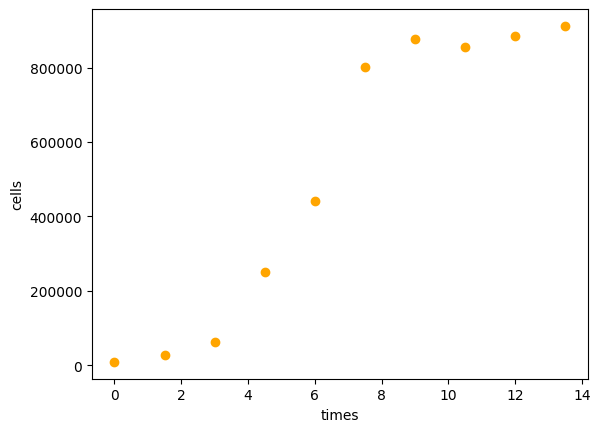

In [4]:
import matplotlib.pyplot as plt
plt.plot(data['times'],data['cells'],'o',color ='orange')
plt.xlabel(data.columns[0])
plt.ylabel(data.columns[1])


However that can be complicated, let's start with the most simple way of fitting a nonlinear ODE model to the data.

### Use of Biological Mechanistic knowledge.
This data is a growth data of the cells where they consume nutrients and we can use the blahblah model

$$
\frac{dN}{dt} = -Q_n \frac{\mu_{max}N}{N+K_s}(P\times10^6)
$$

$$
\frac{dP}{dt} = \frac{\mu_{max}N}{N+K_s} P
$$

### In this dataset the variable 'N' (nutrients) is latent (unobserved)

In [5]:
import numpy as np
from scipy.integrate import odeint
t = np.linspace(0, 15, 100)

def cells_grow(y,t,mu_max,Ks,Qn):
    N, P = y
    dydt = [0,0]
    dydt[0] = -Qn*(mu_max*N)/(N+Ks) *(P*1e6)
    dydt[1] = P*(mu_max*N)/(N+Ks)

    return dydt

def solved_num_cells(y0,t,mu_max,Ks,Qn):
    sol = odeint(cells_grow, y0, t, args=(mu_max,Ks,Qn))
    return sol[:,1]

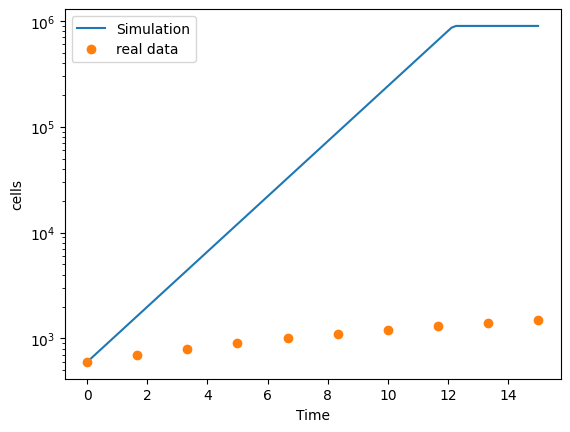

In [39]:
mu_max = 0.6
Ks = 0.09
Qn = 6.7e-10

y0 = [ 6e2, data['cells'][0] ]
num_cells_solved = solved_num_cells(y0,t,mu_max,Ks,Qn)

plt.plot(t,num_cells_solved)
plt.plot(data['times'],data['cells'],'o')
plt.legend(['Simulation','real data'])
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('cells')
plt.show()


In [40]:
import numpy as np
import tensorflow as tf
from scipy.integrate import odeint

# Define the model function
def cells_grow(y, t, mu_max, Ks, Qn):
    N, P = y
    dydt = [0, 0]
    dydt[0] = -Qn * (mu_max * N) / (N + Ks) * (P * 1e6)
    dydt[1] = P * (mu_max * N) / (N + Ks)
    return dydt

# Define the solver function
def solved_num_cells(y0, t, mu_max, Ks, Qn):
    sol = odeint(cells_grow, y0, t, args=(mu_max, Ks, Qn))
    return sol[:, 1]

# Sample data for demonstration (replace with your actual data)
data = {
    'cells': np.array([600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]),
    'times': np.linspace(0, 15, 10)  # times corresponding to the cell counts
}

# Define the cost function for TensorFlow
def cost_function_tf(params, data, log_transformed=True):
    mu_max, Ks, Qn, N0 = params
    y0 = [N0, data['cells'][0]]
    num_cells_solved = solved_num_cells(y0, data['times'], mu_max, Ks, Qn)
    if log_transformed:
        error = np.sum((np.log(num_cells_solved) / 2.303 - np.log(data['cells']) / 2.303) ** 2)
    else:
        error = np.sum((num_cells_solved - data['cells']) ** 2)
    
    return tf.convert_to_tensor(error, dtype=tf.float64)

# Initial guess for the parameters
initial_guess = np.array([0.5, 20, 6.7e-10, 1e3], dtype=np.float64)

# Convert initial guess to TensorFlow variable
params = tf.Variable(initial_guess, dtype=tf.float64)

# Set up the optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
for i in range(1000):  # Number of iterations
    with tf.GradientTape() as tape:
        loss = cost_function_tf(params, data, log_transformed=True)
    grads = tape.gradient(loss, [params])
    optimizer.apply_gradients(zip(grads, [params]))
    if i % 100 == 0:  # Print every 100 iterations
        print(f"Iteration {i}: Loss = {loss.numpy()}")

# Optimized parameters
mu_max_opt, Ks_opt, Qn_opt, N0_opt = params.numpy()
print(f"Optimized parameters: mu_max={mu_max_opt}, Ks={Ks_opt}, Qn={Qn_opt}, N0={N0_opt}")


ValueError: No gradients provided for any variable.